<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h1 style="font-weight: bold; color: white; margin: 0 auto;"> Inceptionv4 (Pretrained) with PyTorch on Drone Dataset  </h1>
</div>



[Dataset Link](https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset)

### Dataset Overview

The Semantic Drone Dataset focuses on semantic understanding of urban scenes for increasing the safety of autonomous drone flight and landing procedures. The imagery depicts more than 20 houses from nadir (bird's eye) view acquired at an altitude of 5 to 30 meters above ground. A high resolution camera was used to acquire images at a size of 6000x4000px (24Mpx). The training set contains 400 publicly available images and the test set is made up of 200 private images.

|  Raw image  |
| ------------- |
|  <img height="400" width="600" src="https://i.ibb.co/8bj6qNH/42.jpg"/>  |
|  Semantic Segmentation  |
| ------------- |
|  <img height="400" width="600" src="https://i.ibb.co/ctxy590/42.png"/>  |

In [1]:
import time
import os
from tqdm.notebook import tqdm

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import imageio 

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torch.nn.functional as F

from PIL import Image
import cv2
import albumentations as A

import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from utils import *
from train import *
from datagen import *

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# Path in Kaggle
# root_img_path = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
# root_mask_path = '../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'


# Path in Local Machine
root_img_path = '../../input/semantic-drone-dataset/dataset/original_images/'
root_mask_path = '../../input/semantic-drone-dataset/dataset/label_images_semantic/'

In [3]:
image_list = os.listdir(root_img_path)
mask_list = os.listdir(root_mask_path)

image_list = [root_img_path + i for i in image_list ] 
mask_list = [root_mask_path + i for i in mask_list ] 

image_list = sorted(image_list)
mask_list = sorted(mask_list)

print('Number of images are ', len(image_list))

print(image_list[0])
print(mask_list[0])

Number of images are  400
../../input/semantic-drone-dataset/dataset/original_images/000.jpg
../../input/semantic-drone-dataset/dataset/label_images_semantic/000.png


(4000, 6000, 3)
(4000, 6000)


Text(0.5, 1.0, 'Masked Image')

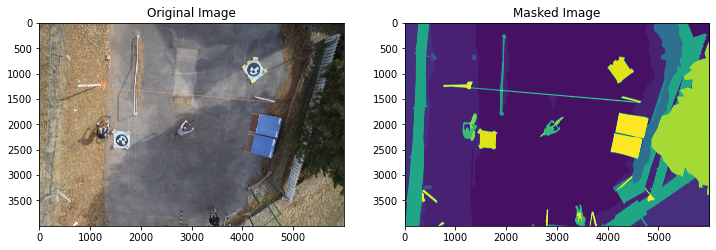

In [4]:
idx = 10
img = imageio.imread(image_list[idx])
print(img.shape)

mask = imageio.imread(mask_list[idx])

print(mask.shape)

fig, arr = plt.subplots(1, 2, figsize=(12, 10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Masked Image')

## For Extracting Filenames or full path from Directory 

In [5]:

df = get_image_id_df(root_img_path)
print(len(df))


400


In [6]:
df.head(2)

,id
0,348
1,287


In [7]:
X_train_and_val, X_test = train_test_split(df["id"].values, test_size = 0.1, random_state=19)
X_train, X_val = train_test_split(X_train_and_val, test_size=0.15, random_state=19)

print('Train Size ', len(X_train))
print('Test Size ', len(X_test))
print('Val Size ', len(X_val))

Train Size  306
Test Size  40
Val Size  54


In [8]:
model = smp.Unet('inceptionv4', encoder_weights = 'imagenet', classes=23, activation = None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16] )


## Execute all DataLoader methods

In [9]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.GridDistortion(p=0.2) ])
t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.GridDistortion(p=0.2) ])

# Bring Datagenerator
train_set = DataGen(root_img_path, root_mask_path, X_train, mean, std, t_train, patch=False )
val_set = DataGen(root_img_path, root_mask_path, X_val, mean, std, t_val, patch=False )

batch_size = 3

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [10]:
model

Unet(
  (encoder): InceptionV4Encoder(
    (features): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (3): Mixed_3a(
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=(1, 1), dilation=1, ceil_mode=False)
        (conv): BasicConv2d(
          (conv): Co

## Mean Intersection-Over-Union

Mean Intersection-Over-Union is a common evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes. IOU is defined as follows:

![Imgur](https://imgur.com/lTGNJKu.png)

where true-positives are those pixels that belong to the class and are correctly predicted as the class, false-negatives are those pixels that belong to the class but are incorrectly predicted as a different class 

False-positives are those pixels that belong to a different class but are predicted as the class. The image below illustrates these sets of pixels for the dog in the image above. 

### The mean IoU over the entire dataset should be calculated as follows:

1. for each class, calculate the total area_intersection and area_union over the entire dataset
2. for each class, iou = total area_intersection / total area_union
3. MIOU = mean of iou for each class



In the Difference image true-positives are indicated by yellow pixels, false-positives are indicated by red pixels and false-negatives are indicated by green pixels.

![Imgur](https://imgur.com/SsFNOBB.png)

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h1 style="font-weight: bold; color: white; margin: 0 auto;"> Training  </h1>
</div>

In [12]:
max_lr = 1e-3
epochs = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay )
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

history = train(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler)


In [ ]:
torch.save(model, 'InceptionV4.pt')

## Execute Plotting Methods

In [ ]:
plot_loss_vs_epoch(history)
plot_iou_score_vs_epoch(history)
plot_accuracy_vs_epoch(history)

## Evaluation on Test Dataset

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)

test_set = TestDataGen(root_img_path, root_mask_path, X_test, transform=t_test )


In [ ]:
image, mask = test_set[3]

pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
test_set_miou = miou_score_from_trained_model(model, test_set)

In [ ]:
test_set_accuracy = pixel_accuracy_from_trained_model(model, test_set)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(image)
ax1.set_title('Original Image')

ax2.imshow(mask)
ax2.set_title('Ground Truth Mask')
ax2.set_axis_off()


ax3.imshow(pred_mask)
ax2.set_title('Predicted Mask')
ax2.set_axis_off()



## Bonus Points

### Why I need patching

I have 3 dimensional data samples ranging in the 6000*4000. Such huge piece of data is too much when I fed them to the network in one piece and therefore Patching is required.

Say you want to create 64x64x64 patches out of the 500x500x500 data sample what do you guys do ?

https://discuss.pytorch.org/t/patch-making-does-pytorch-have-anything-to-offer/33850/7


-----------------------------------------

## PyTorch Official Doc on unfold

https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html

The unfold and fold are used to facilitate "sliding window" operations (like convolutions).

torch.nn.Unfold(kernel_size, dilation=1, padding=0, stride=1)[SOURCE]
Extracts sliding local blocks from a batched input tensor.

-----------------------------------------

## pytorchs fold-and-unfold

https://stackoverflow.com/questions/53972159/how-does-pytorchs-fold-and-unfold-work


`unfold` imagines a tensor as a longer tensor with repeated columns/rows of values 'folded' on top of each other, which is then "unfolded":

- `size` determines how large the folds are
- `step` determines how often it is folded

E.g. for a 2x5 tensor, unfolding it with `step=1`, and patch `size=2` across `dim=1`:

```python
x = torch.tensor([[1,2,3,4,5],
                  [6,7,8,9,10]])
```

```python
>>> x.unfold(1,2,1)
tensor([[[ 1,  2], [ 2,  3], [ 3,  4], [ 4,  5]],
        [[ 6,  7], [ 7,  8], [ 8,  9], [ 9, 10]]])
```

[![enter image description here][1]][1]

`fold` is roughly the opposite of this operation, but "overlapping" values are summed in the predicted_image.


  [1]: https://i.stack.imgur.com/uCrOg.png

-----------------------------------------

  ## `tensor.contiguous()`

  tensor.contiguous() will create a copy of the tensor, and the element in the copy will be stored in the memory in a contiguous way. 